## 🧠 Brain Parcellation Visualization  

### Overview  
This notebook visualizes brain parcellations using **FreeSurfer’s aparc+aseg.mgz** file, overlaying region labels on a native anatomical scan. Each brain region is assigned a unique color, allowing clear distinction between structures.  

### Future Enhancements  
- Ensure **left and right hemisphere regions have the same color**  
- Integrate **FreeSurfer's predefined colors** from `FreeSurferColorLUT.txt`  

### Output  
The visualization displays distinct brain regions in unique colors, overlaid on the anatomical scan.  

In [ ]:
!pip install nibabel nilearn reportlab

In [104]:
import nibabel as nib
from nilearn import image, plotting
import nibabel.freesurfer as fs
from nilearn.image import resample_to_img
import matplotlib.colors as mcolors
from nibabel.freesurfer import read_annot

from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import pandas as pd

import numpy as np
import matplotlib.image as mpimg
import re
import datetime
import os
from dotenv import load_dotenv
import flywheel

from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader

today = datetime.datetime.now()


In [ ]:
display(f"User: {fw.get_current_user().id}")

project=fw_project
display(f"Project: {project.label}")
project = project.reload()

In [ ]:
def get_data(subjects,gear):
    
    for subject in subjects:
        subject = subject.reload()
        sub_label = subject.label
        
        for session in subject.sessions.iter():
            session = session.reload()
            ses_label = session.label

            analyses = session.analyses

            # If there are no analyses containers, we know that this gear was not run
            if len(analyses) == 0:
                run = 'False'
                status = 'NA'
                print('No analysis containers')
            else:

                matches = [asys for asys in analyses if asys.gear_info.get('name') == gear]

                print("Matches: ", len(matches))
                # If there are no matches, the gear didn't run
                if len(matches) == 0:
                    run = 'False'
                    status = 'NA'
                # If there is one match, that's our target
                elif len(matches) == 1:
                    run = 'True'
                    status = matches[0].job.get('state')
                    print(status)

                    for file in matches[0].files:  
                        print(file.name)
                        if file.name.endswith('aparc+aseg.nii.gz') or file.name.endswith('synthSR.nii.gz') or re.search('mrr-axireg.*\.nii.gz', file.name) or re.search('.*\.zip', file.name):
                            parcellation = file
                            print("Found ", file.name)
                            if file :
                                download_dir = Path(f'{sub_label}/{ses_label}/')
                                download_dir.mkdir(parents=True,exist_ok=True)
                                download_path = os.path.join(download_dir , parcellation.name)
                                parcellation.download(download_path)



                else:
                    last_run_date = max([asys.created for asys in matches])
                    last_run_analysis = [asys for asys in matches if asys.created == last_run_date]

                    # There should only be one exact match
                    last_run_analysis = last_run_analysis[0]

                    run = 'True'
                    status = last_run_analysis.job.get('state')

                    for file in last_run_analysis.files:
                        if file.name.endswith('aparc+aseg.nii.gz') or file.name.endswith('synthSR.nii.gz') or re.search('mrr-axireg.*\.nii.gz', file.name) or re.search('.*\.zip', file.name):
                            parcellation = file
                            print("Found ", file.name)
                            if file :
                                download_dir = Path(f'{sub_label}/{ses_label}/')
                                download_dir.mkdir(parents=True,exist_ok=True)
                                download_path = os.path.join(download_dir , parcellation.name)
                                parcellation.download(download_path)
        break


Get output from the MRR and recon-all gears

In [ ]:
gear = "mrr"
subjects = project.subjects.iter()
get_data(subjects,gear)

In [ ]:
gear = "recon-all-clinical"
subjects = project.subjects.iter()
get_data(subjects,gear)

<>:28: SyntaxWarning: invalid escape sequence '\.'
<>:28: SyntaxWarning: invalid escape sequence '\.'
/var/folders/2c/7lfc22z52cqgy2qyv9xkt9240000gn/T/ipykernel_22125/705447565.py:28: SyntaxWarning: invalid escape sequence '\.'
  elif re.search('mrr-axireg.*\.nii.gz', file):


OI_6052_3M


/var/folders/2c/7lfc22z52cqgy2qyv9xkt9240000gn/T/ipykernel_22125/705447565.py:39: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_segmentation = image.resample_to_img(segmentation, native_scan, interpolation="nearest")
/Users/Hajer/unity/.unityEnv/lib/python3.13/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(


Plot saved for  OI_6052_3M


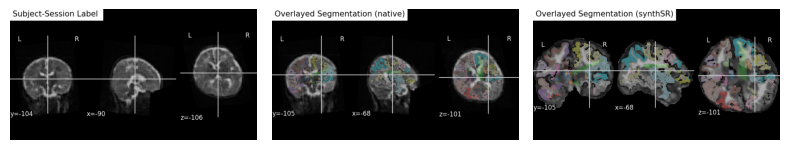

OP_7712_3M


/var/folders/2c/7lfc22z52cqgy2qyv9xkt9240000gn/T/ipykernel_22125/705447565.py:28: SyntaxWarning: invalid escape sequence '\.'
  elif re.search('mrr-axireg.*\.nii.gz', file):


KeyboardInterrupt: 

In [108]:
synthSR_scan_path = "" 
native_scan_path = ""
segmentation_path = ""
subjects = project.subjects.iter()

for subject in subjects:
    subject = subject.reload()
    sub_label = subject.label
    print(sub_label)
    
    for session in subject.sessions.iter():
        session = session.reload()
        ses_label = session.label
        
        try:
    
            files = os.listdir(path=f"{sub_label}/{ses_label}")

            for file in files:
                if file.endswith('aparc+aseg.nii.gz'):
                    segmentation_path = os.path.join(f"{sub_label}/{ses_label}",file)


                elif file.endswith('synthSR.nii.gz'):
                    synthSR_scan_path = os.path.join(f"{sub_label}/{ses_label}",file)


                elif re.search('mrr-axireg.*\.nii.gz', file):
                    native_scan_path = os.path.join(f"{sub_label}/{ses_label}",file)


            native_scan = nib.load(native_scan_path)
            segmentation = nib.load(segmentation_path)

            if native_scan and segmentation: #if files are not empty

                
                # Resample the segmentation to match the native scan space if needed
                resampled_segmentation = image.resample_to_img(segmentation, native_scan, interpolation="nearest")
                parc_data = resampled_segmentation.get_fdata()

                # Get unique labels (excluding 0 which is background)
                unique_labels = np.unique(parc_data)
                unique_labels = unique_labels[unique_labels > 0]  # Remove background

                # Generate distinct colors for each region
                num_labels = len(unique_labels)
                colors = plt.cm.tab20(np.linspace(0, 1, num_labels))  # Use tab20 colormap for categorical data

                # Create a colormap that maps each label to a color
                label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}
                cmap_list = [label_to_color.get(label, (0, 0, 0, 0)) for label in range(int(unique_labels.max()) + 1)]  # Ensure mapping
                cmap = mcolors.ListedColormap(cmap_list)


                plotting.plot_anat(
                    native_scan_path,
                    title=f"Subject-Session Label ",
                    display_mode="ortho",
                    output_file=f"{sub_label}/{ses_label}/{sub_label}_native_scan.png"
                )

                plotting.plot_roi(
                    resampled_segmentation,
                    bg_img=native_scan_path,
                    
                    alpha=0.4,  
                    cmap=cmap,  
                    threshold=0.5, 
                    title="Overlayed Segmentation (native)" ,
                    output_file=f"{sub_label}/{ses_label}/{sub_label}_Overlayed Segmentation (native).png"
                )

                plotting.plot_roi(
                    resampled_segmentation,
                    bg_img=synthSR_scan_path,
                    title="Overlayed Segmentation (synthSR)",
                    alpha=0.4,  # Adjust transparency
                    cmap=cmap,
                    threshold=0.5,  # Remove noisy boundaries below the threshold,
                    output_file=f"{sub_label}/{ses_label}/{sub_label}_Overlayed Segmentation (synthSR).png"
                )

                image1_path = f"{sub_label}/{ses_label}/{sub_label}_native_scan.png"
                image2_path = f"{sub_label}/{ses_label}/{sub_label}_Overlayed Segmentation (native).png"
                image3_path = f"{sub_label}/{ses_label}/{sub_label}_Overlayed Segmentation (synthSR).png"

                img1 = mpimg.imread(image1_path)
                img2 = mpimg.imread(image2_path)
                img3 = mpimg.imread(image3_path)

                fig, axes = plt.subplots(1, 3, figsize=(8, 15))

                axes[0].imshow(img1)
                axes[0].axis('off') 

                axes[1].imshow(img2)
                axes[1].axis('off')

                axes[2].imshow(img3)
                axes[2].axis('off')

                plt.tight_layout()
                plt.savefig(f"{sub_label}/{ses_label}/{sub_label}_segmentation_overlays_vertical.png", dpi=300,bbox_inches='tight')
                print("Plot saved for ", sub_label)
                plt.show()
                plt.close()
                
        except Exception as e:
            print('Exception found: ', e)

In [ ]:
synthSR_scan_path = "" 
native_scan_path = ""
segmentation_path = ""

# Constants
page_width, page_height = letter
border_margin = 1  # Margin from top/bottom
plot_height = 150    # Approximate height of each plot in the PDF
plot_spacing = 1    # Spacing between plots
usable_height = page_height - 2 * border_margin  # Usable page height
plots_per_page = usable_height // (plot_height + plot_spacing)  # Max plots per page

# Create a new PDF
output_pdf = f"Segmentation_QC_Report_{project.label}.pdf"
pdf = canvas.Canvas(output_pdf, pagesize=letter)

# Vertical position tracker
y_position = page_height - border_margin

# Iterate through subjects
subjects = project.subjects.iter()
files = []
for subject in subjects:
    
    subject = subject.reload()
    sub_label = subject.label
    
    for session in subject.sessions.iter():
        session = session.reload()
        ses_label = session.label
        
        try:
            plot_path = f"{sub_label}/{ses_label}/{sub_label}_segmentation_overlays_vertical.png"

            image = ImageReader(plot_path)
            # Get the width and height of the image
            img_width, img_height = image.getSize()

            # Add plot to PDF
            if y_position - plot_height < border_margin:  # Check if a new page is needed
                pdf.showPage()
                y_position = page_height - border_margin  # Reset y_position

            pdf.drawImage(plot_path, border_margin, y_position - plot_height, width=page_width - 2 * border_margin, height=plot_height)

            # Update y_position
            y_position -= plot_height + plot_spacing
        except Exception as e:
            print("Exception caught: ", e)



# Save the PDF
pdf.save()
print(f"PDF saved to {output_pdf}")


In [ ]:
analysis_label = "Visualise Parcellations"
analysis = session.add_analysis(label=analysis_label)
analysis.upload_output(output_pdf)